In [1]:
from collections import Counter

import pandas as pd


stopwords = {'ourselves', 'hers', 'between', 'yourself', 'but', 'again', 'there', 'about', 'once', 'during', 'out', 'very', 'having', 'with', 'they', 'own', 'an', 'be', 'some', 'for', 'do', 'its', 'yours', 'such', 'into', 'of', 'most', 'itself', 'other', 'off', 'is', 's', 'am', 'or', 'who', 'as', 'from', 'him', 'each', 'the', 'themselves', 'until', 'below', 'are', 'we', 'these', 'your', 'his', 'through', 'don', 'nor', 'me', 'were', 'her', 'more', 'himself', 'this', 'down', 'should', 'our', 'their', 'while', 'above', 'both', 'up', 'to', 'ours', 'had', 'she', 'all', 'no', 'when', 'at', 'any', 'before', 'them', 'same', 'and', 'been', 'have', 'in', 'will', 'on', 'does', 'yourselves', 'then', 'that', 'because', 'what', 'over', 'why', 'so', 'can', 'did', 'not', 'now', 'under', 'he', 'you', 'herself', 'has', 'just', 'where', 'too', 'only', 'myself', 'which', 'those', 'i', 'after', 'few', 'whom', 't', 'being', 'if', 'theirs', 'my', 'against', 'a', 'by', 'doing', 'it', 'how', 'further', 'was', 'here', 'than'}

# Import Data

In [2]:
df = pd.read_csv('AI_ML_Challenge_Training_Data_Set_1_v1.csv')

In [3]:
df.head()

,Clause ID,Clause Text,Classification
0,1588,18. Governing Law: This Agreement shall be gov...,0
1,1146,"1.8 Modification. We may modify, update, or di...",1
2,4792,Except as otherwise expressly provided in this...,0
3,2759,8.3. The benefit and burdens of this Ag...,1
4,4400,DEFINITIONS,0


# Missing Data

In [4]:
df.isnull().sum()

Clause ID         0
Clause Text       0
Classification    0
dtype: int64

# Duplication

In [5]:
df['Clause Text'].duplicated().sum()

526

Several hundred dupes. Hopefully a dupe has the same class consistently.

In [6]:
duplicate_clauses = df[df['Clause Text'].duplicated()]['Clause Text'].tolist()

In [7]:
dupe_df = df[df['Clause Text'].isin(duplicate_clauses)].sort_values(by='Clause Text').reset_index()

In [8]:
dupe_df[dupe_df['Classification'] == 1]

,index,Clause ID,Clause Text,Classification
386,3314,5249,Headings. The headings of the sections of this...,1
472,7104,6371,Nothing contained herein shall be construed i...,1
473,7701,6372,Nothing contained herein shall be construed i...,1
642,5084,8315,THIS AGREEMENT DOES NOT LIMIT OR DISCLAIM ANY ...,1
643,3735,8316,THIS AGREEMENT DOES NOT LIMIT OR DISCLAIM ANY ...,1
644,7465,8314,THIS AGREEMENT DOES NOT LIMIT OR DISCLAIM ANY ...,1
645,428,8313,THIS AGREEMENT DOES NOT LIMIT OR DISCLAIM ANY ...,1
646,5019,8310,THIS AGREEMENT DOES NOT LIMIT OR DISCLAIM ANY ...,1
647,6776,8317,THIS AGREEMENT DOES NOT LIMIT OR DISCLAIM ANY ...,1
648,4513,8312,THIS AGREEMENT DOES NOT LIMIT OR DISCLAIM ANY ...,1


**The first instance (Clause ID 5249) only appears once, suggesting this clause is labeled once as compliant and once as non-compliant.**

In [9]:
df[df['Clause Text'] == dupe_df.iloc[311]['Clause Text']]

,Clause ID,Clause Text,Classification
873,4674,END USER LICENSE AGREEMENT,0
5252,4675,END USER LICENSE AGREEMENT,0


What about the other clause in all caps that appears several times?

In [10]:
df[df['Clause Text'] == dupe_df.iloc[500]['Clause Text']]

,Clause ID,Clause Text,Classification
6185,6696,Please refer to the COMPANY student license re...,0
6290,6695,Please refer to the COMPANY student license re...,0


phew!

# Class Balance

In [11]:
df['Classification'].value_counts()

0    6407
1    1472
Name: Classification, dtype: int64

In [12]:
1472 / 6407

0.22974871234587171

# Clause Descriptive Stats

## Number of words per clause

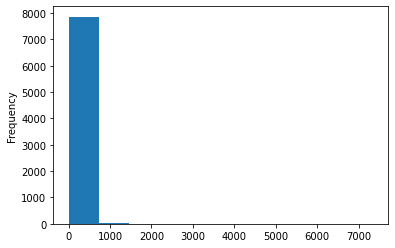

In [13]:
df['Clause Text'].apply(lambda x: len(x.split())).plot(kind='hist')

In [14]:
df['n_words'] = df['Clause Text'].apply(lambda x: len(x.split()))
df.groupby(by='Classification')['n_words'].describe()

,count,mean,std,min,25%,50%,75%,max
Classification,,,,,,,,
0,6407.0,69.228968,134.992024,0.0,14.0,39.0,85.0,7347.0
1,1472.0,126.106658,100.864126,2.0,60.0,98.0,163.0,982.0


In [15]:
# t-test for difference in means
from scipy import stats
a = df[df['Classification'] == 1]['n_words']
b = df[df['Classification'] == 0]['n_words']
test_res = stats.ttest_ind(a, b)
test_res.pvalue

1.4349538376677368e-51

In [16]:
test_res.pvalue/2

7.174769188338684e-52

In [17]:
# should be one-sided b/c we're assuming negative samples have fewer words
test_res.pvalue/2 < .05 and test_res.statistic > 0

True

This test suggests that there is a statistically signficant difference in the population mean of word length between positive and negative clauses. This makes me dubious of the data generation process because a "clause" certianly cannot be just one or a few words.

In [18]:
df[df['n_words'] == 1]['Classification'].value_counts()

0    260
Name: Classification, dtype: int64

In [19]:
260 / df.shape[0]

0.032999111562381014

In [20]:
df[df['n_words'] <= 3]['Classification'].value_counts()

0    779
1      4
Name: Classification, dtype: int64

In [21]:
(779 + 4) / df.shape[0]

0.09937809366670897

In [22]:
df[df['Classification'] == 1]

,Clause ID,Clause Text,Classification,n_words
1,1146,"1.8 Modification. We may modify, update, or di...",1,84
3,2759,8.3. The benefit and burdens of this Ag...,1,22
5,3926,"COMPANY warrants that the SOFTWARE will, for a...",1,90
6,2600,7.1\tTypes of Damages. NEITHER PARTY WILL BE ...,1,101
10,2658,8. Limitation of Liability \r\nNEITHER...,1,117
...,...,...,...,...
7852,5593,"INDEMNITY\r\n\r\nYou agree to indemnify, defen...",1,72
7853,4271,Customer may renew its Imagery license agreeme...,1,13
7872,2789,8.8 This Agreement shall be governed by...,1,73
7875,8456,"This End User License Agreement (""EULA"") is a ...",1,23


## Common Words

In [23]:
noncomplinat_words = [word for word in " ".join(df[df['Classification'] == 1]['Clause Text'].str.lower()).split() if word not in stopwords]
complinat_words = [word for word in " ".join(df[df['Classification'] == 0]['Clause Text'].str.lower()).split() if word not in stopwords]

In [24]:
Counter(noncomplinat_words).most_common(10)

[('company', 2810),
 ('shall', 1501),
 ('agreement', 1347),
 ('software', 1133),
 ('customer', 1127),
 ('use', 1044),
 ('may', 988),
 ('services', 870),
 ('party', 869),
 ('terms', 817)]

In [25]:
Counter(complinat_words).most_common(10)

[('company', 6523),
 ('software', 3695),
 ('shall', 3287),
 ('use', 2902),
 ('agreement', 2434),
 ('may', 2134),
 ('customer', 2132),
 ('services', 1687),
 ('information', 1581),
 ('license', 1570)]

Not a lot of diversity here, suggesting that tf-idf will likely identify the influential words.